In [42]:
import os
import cv2
import random
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Activation, Dropout

In [43]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
!unzip /content/drive/MyDrive/data/archive.zip

Archive:  /content/drive/MyDrive/data/archive.zip
replace New Masks Dataset/Test/Mask/2070.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: New Masks Dataset/Test/Mask/2070.jpg  
replace New Masks Dataset/Test/Mask/2072.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: New Masks Dataset/Test/Mask/2072.jpg  
  inflating: New Masks Dataset/Test/Mask/2083.jpg  
  inflating: New Masks Dataset/Test/Mask/2085.jpg  
  inflating: New Masks Dataset/Test/Mask/2086.jpg  
  inflating: New Masks Dataset/Test/Mask/2110.jpg  
  inflating: New Masks Dataset/Test/Mask/2113.jpg  
  inflating: New Masks Dataset/Test/Mask/2114.jpeg  
  inflating: New Masks Dataset/Test/Mask/2130.jpg  
  inflating: New Masks Dataset/Test/Mask/2132.jpg  
  inflating: New Masks Dataset/Test/Mask/2135.jpg  
  inflating: New Masks Dataset/Test/Mask/2154.png  
  inflating: New Masks Dataset/Test/Mask/2158.png  
  inflating: New Masks Dataset/Test/Mask/2159.png  
  inflating: New Masks Dataset/Test/Mask/2160.png

In [45]:
DATA_DIR = '/content/New Masks Dataset'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'Train')
VALID_DATA_DIR = os.path.join(DATA_DIR, 'Validation')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'Test')

In [46]:
IMG_SIZE = 227
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)

print(CATEGORIES)

['Non Mask', 'Mask']


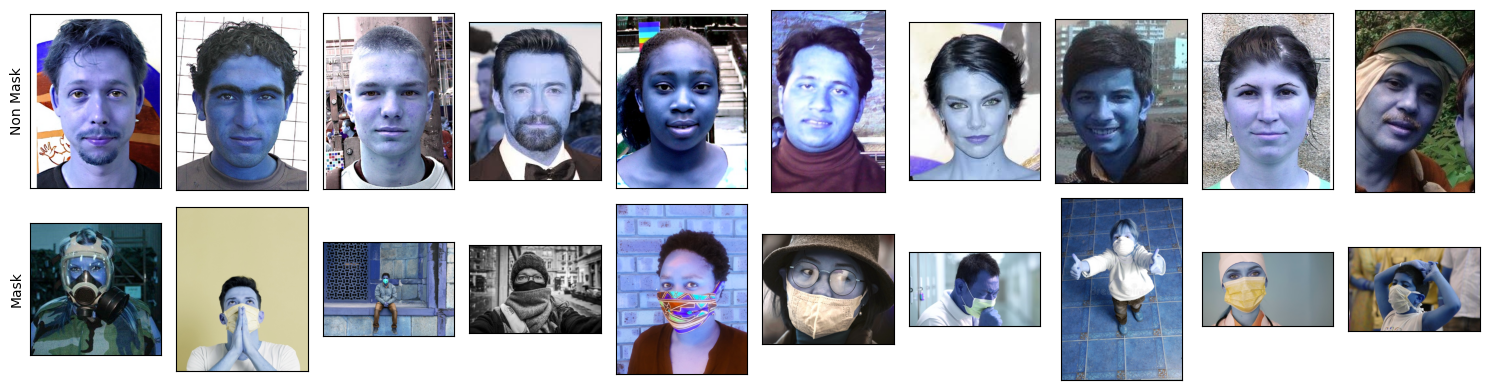

In [47]:
plt.figure(figsize=(15,4))
i=0
for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(2,10,i+1)
        plt.imshow(img_array)
        if i%10 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%10 == 0:
            break

plt.tight_layout()
plt.show()

In [48]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   # read the image
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize the image
            training_data.append([img_resized, class_num])
        except WException as e:
            pass

print(len(training_data))

100%|██████████| 300/300 [00:03<00:00, 82.41it/s]

600


In [49]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except WException as e:
            pass

print(len(test_data))

100%|██████████| 50/50 [00:00<00:00, 78.43it/s]

100


In [50]:
valid_data = []

for c in CATEGORIES:
    path = os.path.join(VALID_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            valid_data.append([img_resized, class_num])
        except WException as e:
            pass

print(len(valid_data))

100%|██████████| 153/153 [00:03<00:00, 38.72it/s]

306


In [51]:
random.shuffle(training_data)
random.shuffle(valid_data)
random.shuffle(test_data)

In [52]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1,227,227,3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (600, 227, 227, 3) Y_train= (600,)


In [53]:
X_valid = []
Y_valid = []

for img, label in valid_data:
    X_valid.append(img)
    Y_valid.append(label)

X_valid = np.array(X_valid).astype('float32').reshape(-1,227,227,3)
Y_valid = np.array(Y_valid)

print(f"X_valid= {X_valid.shape} Y_valid= {Y_valid.shape}")

X_valid= (306, 227, 227, 3) Y_valid= (306,)


In [54]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_test= (100, 227, 227, 3) Y_test= (100,)


In [55]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [115]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.30))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(16, activation='relu'))

model.add(Dense(len(CATEGORIES)))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 225, 225, 64)      1792      
                                                                 
 activation_35 (Activation)  (None, 225, 225, 64)      0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 110, 110, 256)     147712    
                                                                 
 activation_36 (Activation)  (None, 110, 110, 256)     0         
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 55, 55, 256)      0         
 g2D)                                                 

In [116]:
history=model.fit(X_train, Y_train, batch_size=64, epochs=50, validation_split=0.3, verbose=1)


Epoch 1/50
7/7 [==============================] - 7s 581ms/step - loss: 77.2439 - accuracy: 0.4024 - val_loss: 1.0891 - val_accuracy: 0.5056
Epoch 2/50
7/7 [==============================] - 3s 451ms/step - loss: 0.8511 - accuracy: 0.5190 - val_loss: 1.0865 - val_accuracy: 0.5000
Epoch 3/50
7/7 [==============================] - 3s 443ms/step - loss: 0.7331 - accuracy: 0.5214 - val_loss: 1.0850 - val_accuracy: 0.5056
Epoch 4/50
7/7 [==============================] - 3s 440ms/step - loss: 0.7562 - accuracy: 0.5143 - val_loss: 1.0822 - val_accuracy: 0.5056
Epoch 5/50
7/7 [==============================] - 3s 454ms/step - loss: 0.7635 - accuracy: 0.4857 - val_loss: 1.0814 - val_accuracy: 0.5278
Epoch 6/50
7/7 [==============================] - 3s 451ms/step - loss: 0.7488 - accuracy: 0.5238 - val_loss: 1.0786 - val_accuracy: 0.5167
Epoch 7/50
7/7 [==============================] - 3s 449ms/step - loss: 0.7182 - accuracy: 0.5405 - val_loss: 1.0737 - val_accuracy: 0.5167
Epoch 8/50
7/7 [===

In [117]:
validation_loss, validation_accuracy = model.evaluate(X_test, Y_test)

4/4 [==============================] - 0s 39ms/step - loss: 1.5569 - accuracy: 0.7200


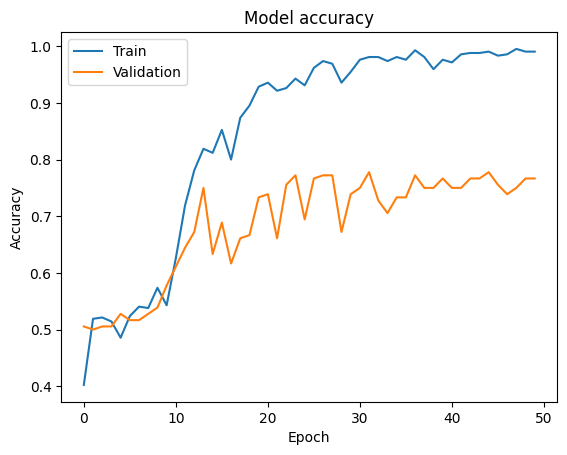

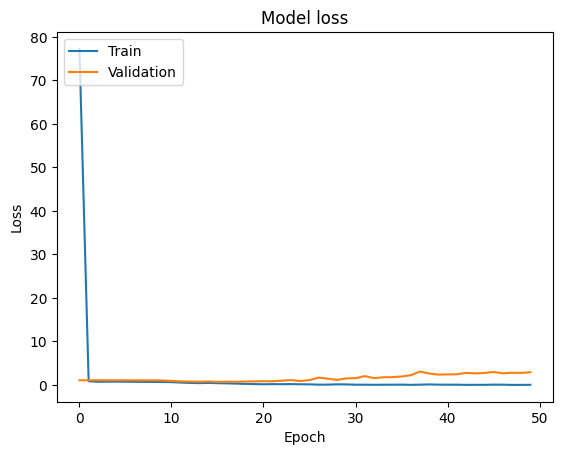

In [118]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [119]:
model.save("/content/drive/MyDrive/face_Mask_Detect/mask.model", save_format="h5")

In [120]:


# Load the trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/face_Mask_Detect/mask.model")


face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + '/content/drive/MyDrive/data/haarcascade_frontalface_default.xml')

def detect_face_mask(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face_roi = gray[y:y+h, x:x+w]
        face_roi_resized = cv2.resize(face_roi, (IMG_SIZE, IMG_SIZE))
        face_roi_resized = np.expand_dims(face_roi_resized, axis=0)
        face_roi_resized = face_roi_resized.reshape(-1, IMG_SIZE, IMG_SIZE, 1).astype('float32')

        mask_prob = model.predict(face_roi_resized)[0][1]
        mask_label = "Mask" if mask_prob > 0.5 else "No Mask"
        color = (0, 255, 0) if mask_label == "Mask" else (255, 0, 0)

        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        cv2.putText(frame, mask_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)

    return frame

#
cap = cv2.VideoCapture(1)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Unable to capture frame from webcam.")
        break

    try:
        result_frame = detect_face_mask(frame)

        cv2.imshow("Face Mask Detection", result_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    except Exception as e:
        print("Error:", str(e))

cap.release()
cv2.destroyAllWindows()


Error: Unable to capture frame from webcam.
